In [211]:
import pandas as pd

import protfasta
import requests
import re
import warnings
warnings.filterwarnings("ignore")
import glob


from Bio import AlignIO
import matplotlib.pyplot as plt
from Bio.Align import AlignInfo

from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import rich
from rich_msa import RichAlignment

import logomaker

#Import modules
import gzip, logomaker, matplotlib.pyplot as plt, numpy as np, os, pandas as pd, protfasta


import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import itertools

from scipy import stats

# 6. Calculate average percent identity per AA per AD

In [18]:
AD_alignments = glob.glob("../data/zoonomia_toga_mca/all_AD_alignments/*")
all_avg_percent_identities_df = []

all_percent_identities_df = []

for AD in AD_alignments:
    # For each AD, iterate through positions of alignment    
    # Load the alignment
    alignment = AlignIO.read(AD, "fasta")
    
    # Initialize a list to store percent identity for each position
    percent_identities = []

    for record in alignment:
        if "REFERENCE" in record.id:
            reference_seq = record.seq
            break
    
    AAs = []
    percent_identities = []
    positions = []
    
    # Iterate over each position in the alignment
    for i in range(alignment.get_alignment_length()):
        ref_AA = reference_seq[i]
        if ref_AA == "X" or ref_AA == "-":
            print(AD)
        
        # Get the column (position) for all sequences
        column = alignment[:, i]
    
        # Calculating percent identity
        count = column.count(ref_AA)
        percent_identity = 100 * count / len(column)
    
        AAs.append(ref_AA)
        percent_identities.append(percent_identity)
        positions.append(i)
    
    percent_identities_df = pd.DataFrame({"AA" : AAs, "percent_identity" : percent_identities, "pos" : positions})
    percent_identities_df["AD"] = AD.split("/")[-1].split(".")[0]

    all_percent_identities_df.append(percent_identities_df)    
    avg_percent_identities_df = percent_identities_df[["AA", "percent_identity"]].groupby("AA").mean()
    avg_percent_identities_df["AD"] = AD.split("/")[-1].split(".")[0]

    # # Print percent identity for each position
    # for i, p_id in enumerate(percent_identities):
    #     print(f"Position {i + 1}: {p_id:.2f}%")
    all_avg_percent_identities_df.append(avg_percent_identities_df)

all_avg_percent_identities_df = pd.concat(all_avg_percent_identities_df)
all_avg_percent_identities_df = all_avg_percent_identities_df.reset_index()
display(all_avg_percent_identities_df)

percent_identities_df = pd.concat(all_percent_identities_df)
#percent_identities_df = percent_identities_df.reset_index()
percent_identities_df

,AA,percent_identity,AD
0,A,97.029240,SRF_406-508
1,D,99.052632,SRF_406-508
2,E,77.684211,SRF_406-508
3,F,99.684211,SRF_406-508
4,G,87.289474,SRF_406-508
...,...,...,...
11379,S,91.345504,FOS_209-371
11380,T,79.344151,FOS_209-371
11381,V,81.009128,FOS_209-371
11382,W,97.160243,FOS_209-371


,AA,percent_identity,pos,AD
0,H,99.368421,0,SRF_406-508
1,M,99.578947,1,SRF_406-508
2,M,99.578947,2,SRF_406-508
3,Y,99.578947,3,SRF_406-508
4,P,98.947368,4,SRF_406-508
...,...,...,...,...
158,P,97.160243,158,FOS_209-371
159,S,97.160243,159,FOS_209-371
160,S,97.160243,160,FOS_209-371
161,D,97.160243,161,FOS_209-371


In [7]:
all_avg_percent_identities_df["AA"].value_counts()

AA
L    642
S    637
P    634
A    628
G    622
D    616
V    610
E    609
T    608
Q    604
F    583
N    552
R    550
M    548
I    544
H    534
Y    533
K    508
C    457
W    365
Name: count, dtype: int64

In [8]:
avg_conservation_order = all_avg_percent_identities_df[["AA", "percent_identity"]].groupby("AA").median().sort_values(by = "percent_identity", ascending = False)
avg_conservation_order

,percent_identity
AA,
W,97.330595
Y,96.494845
F,96.356108
K,96.279948
C,96.127563
L,95.631127
R,95.574284
Q,95.354023
H,95.238095


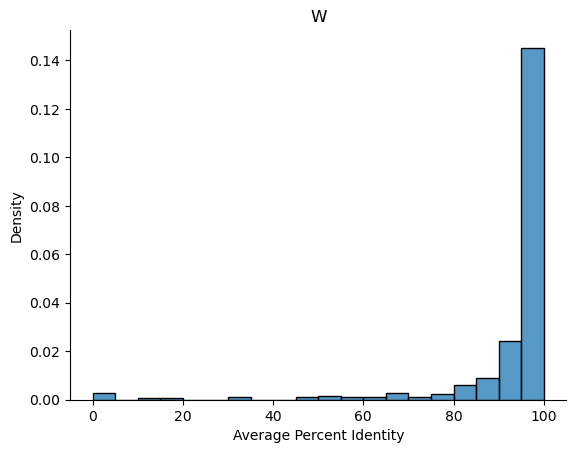

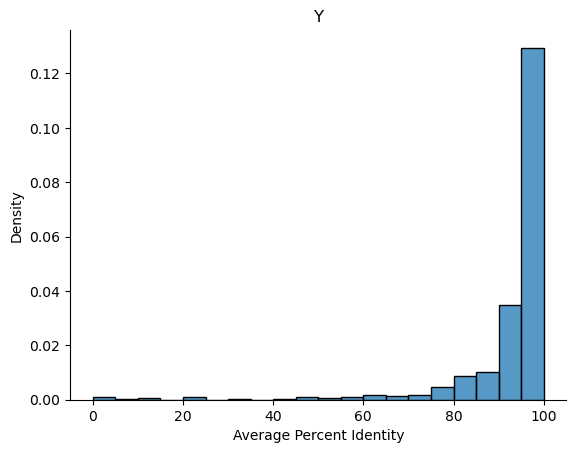

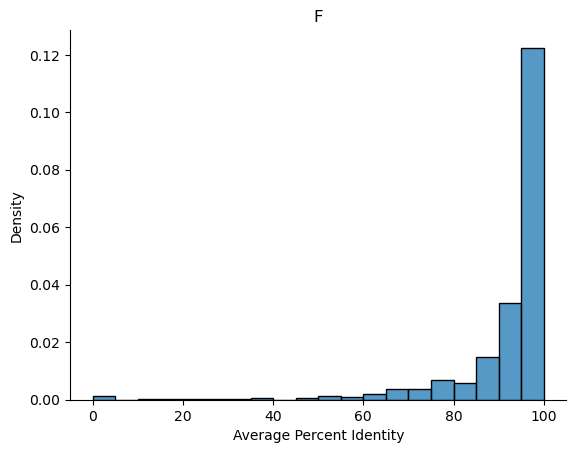

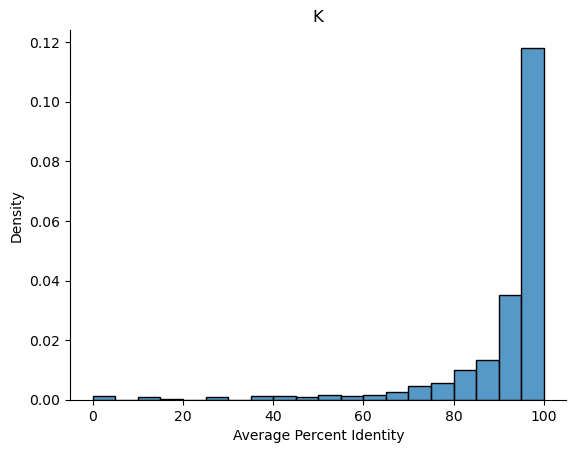

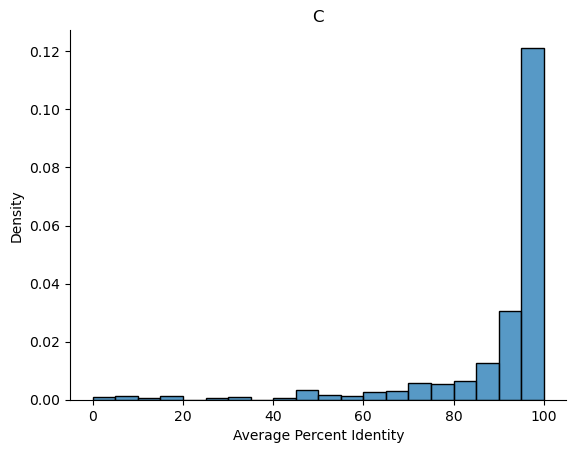

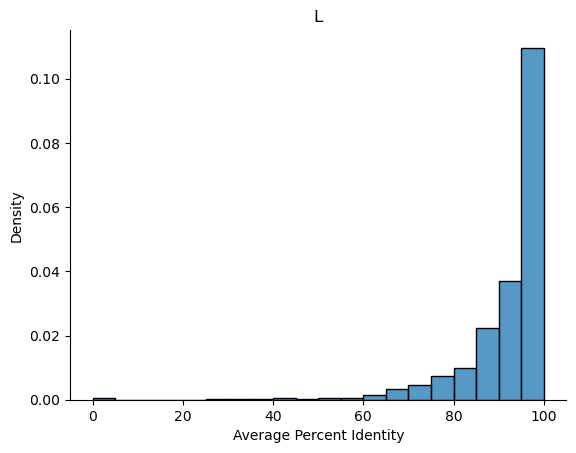

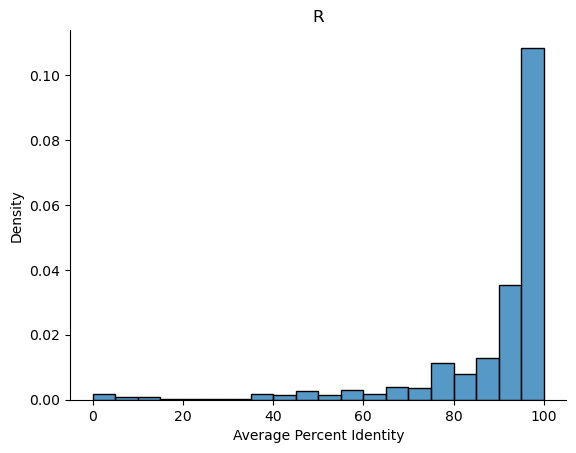

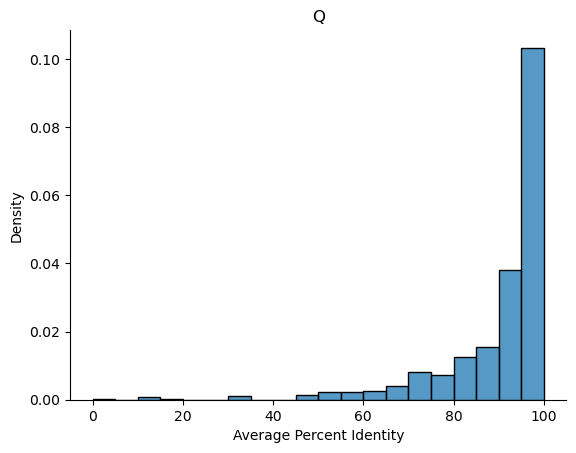

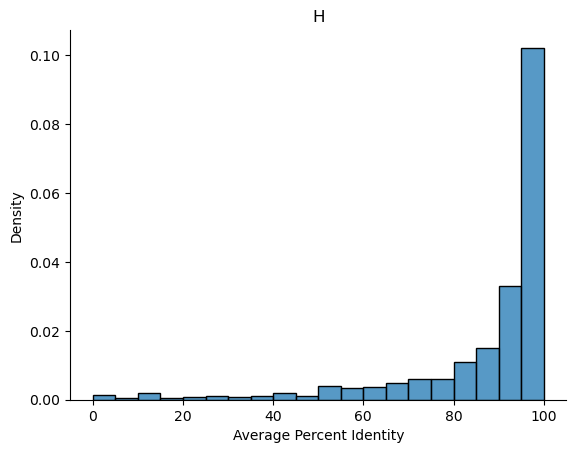

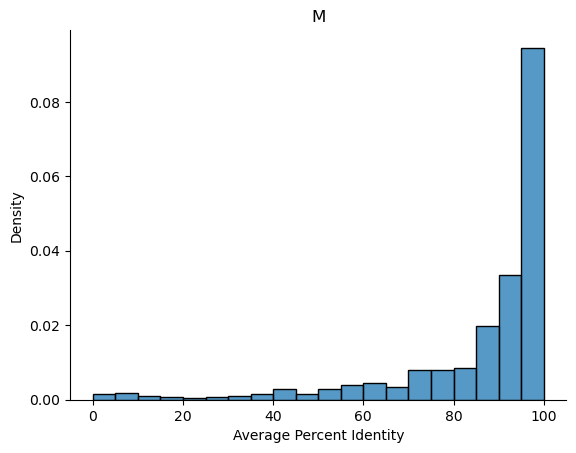

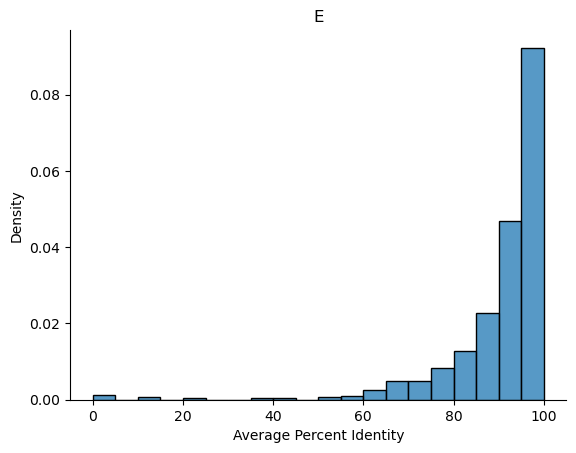

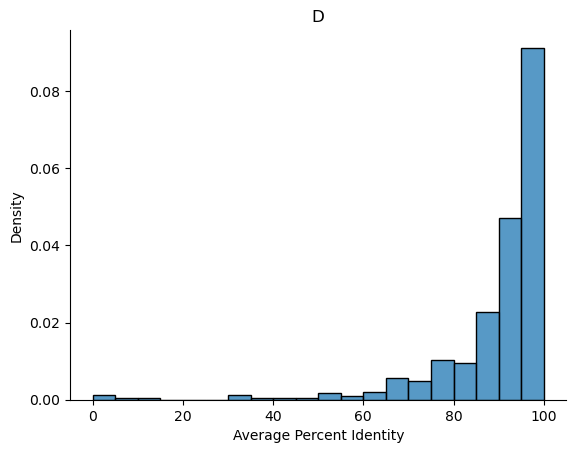

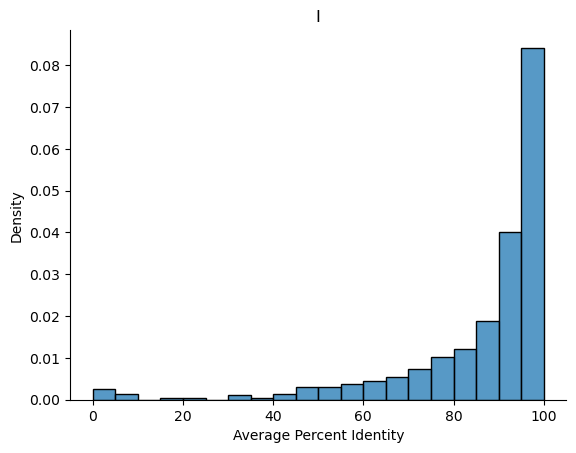

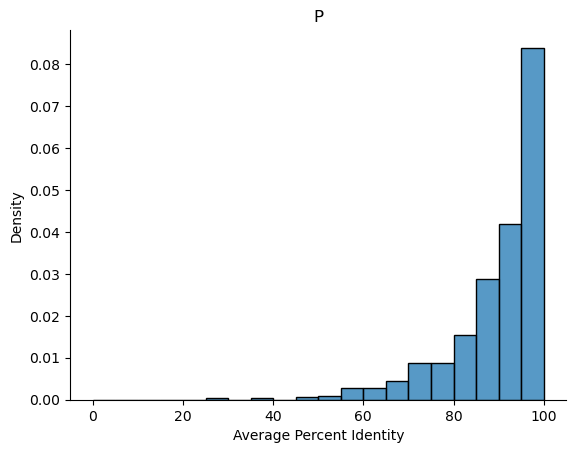

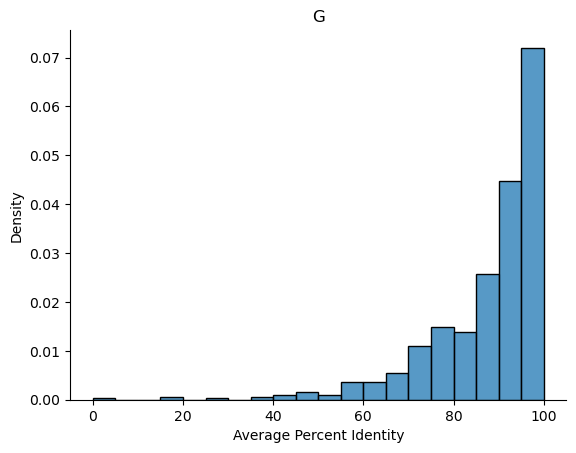

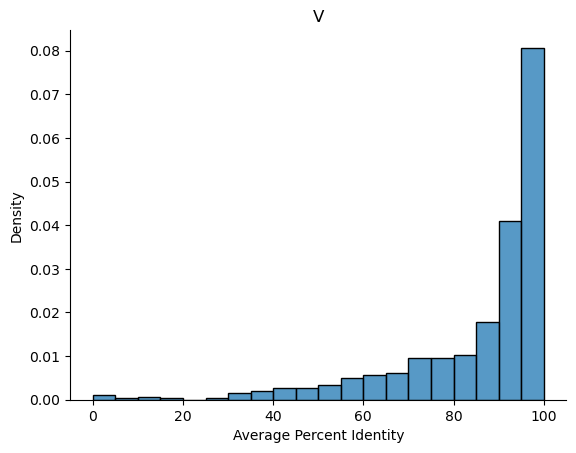

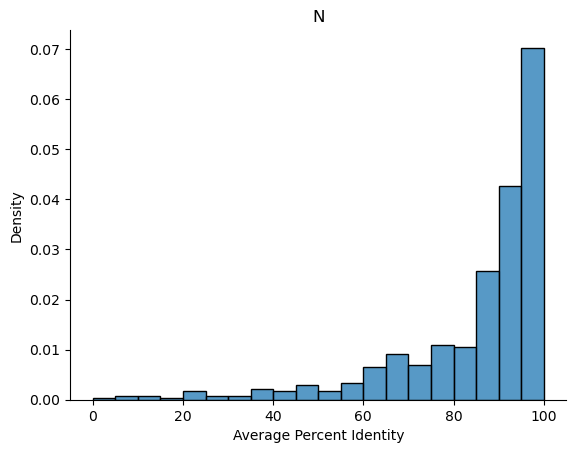

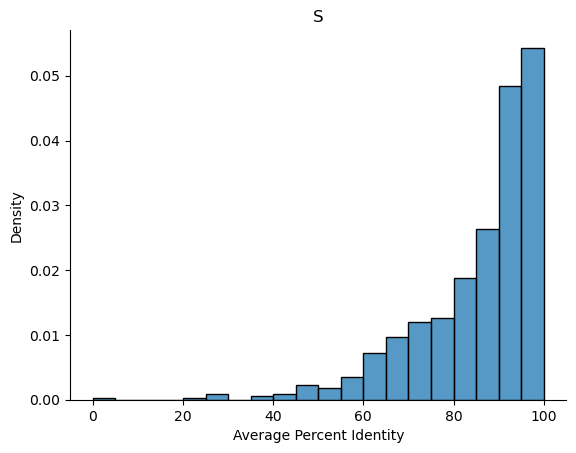

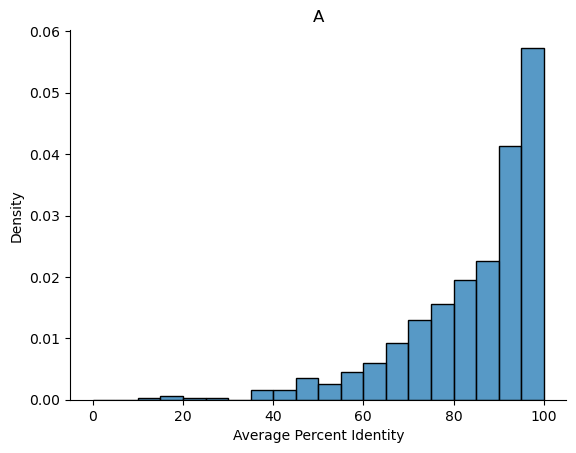

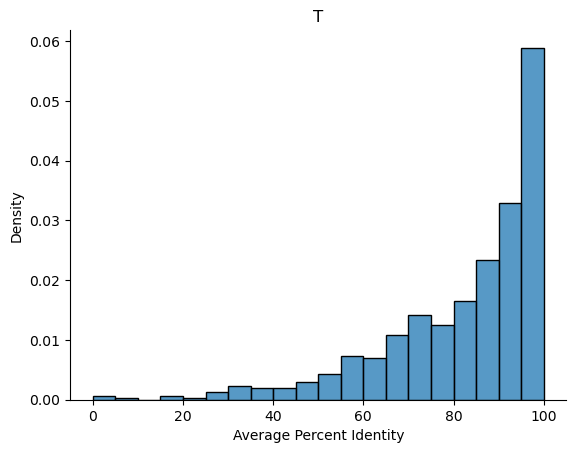

In [9]:
for AA in avg_conservation_order.index:
    AA_rows = all_avg_percent_identities_df[all_avg_percent_identities_df["AA"] == AA]
    sns.histplot(AA_rows["percent_identity"], bins = np.arange(0, 105, 5), stat = 'density')
    sns.despine()
    plt.title(AA)
    plt.xlabel("Average Percent Identity")
    plt.show()

In [10]:
avg_conservation_order.index

Index(['W', 'Y', 'F', 'K', 'C', 'L', 'R', 'Q', 'H', 'M', 'E', 'D', 'I', 'P',
       'G', 'V', 'N', 'S', 'A', 'T'],
      dtype='object', name='AA')

In [11]:
all_avg_percent_identities_df['sort_order'] = pd.Categorical(all_avg_percent_identities_df['AA'], ordered=True, categories=avg_conservation_order.index)
all_avg_percent_identities_df = all_avg_percent_identities_df.sort_values('sort_order')
all_avg_percent_identities_df

,AA,percent_identity,AD,sort_order
6669,W,99.768519,AR_1-494,W
8910,W,98.856549,RORA_272-385,W
933,W,93.545082,BRWD3_1041-1140,W
5494,W,94.908350,NFRKB_1-80,W
4899,W,96.770833,JADE2_511-590,W
...,...,...,...,...
2033,T,97.038567,FOXJ2_1-27,T
4307,T,88.578089,SETD1B_11-90,T
2051,T,88.812910,CAMTA1_422-501,T
698,T,75.745614,RXRA_1-134,T


In [8]:
# All plotting controls

amino_acid_colors_white = {
    # Purples
    'F': '#306BAC',  
    'W': '#306BAC',
    'L': '#306BAC',
    'Y': '#306BAC',
    
    # Reds
    'D': '#D04741', 
    'E': '#D04741', 

    # Blues
    'K': '#52B0E1', 
    'R': '#52B0E1', 

    # black
    'S': '#000000', 
    'P': '#000000',

    # greys
    'A': '#787878',
    'V': '#787878',
    'I': '#787878',
    'M': '#787878',
    'T': '#787878',
    'G': '#787878',
    'C': '#787878',
    'N': '#787878',
    'Q': '#787878',
    'H': '#787878',  
     
    '-': "#FFFFFF", 
    "X": "#787878"
}


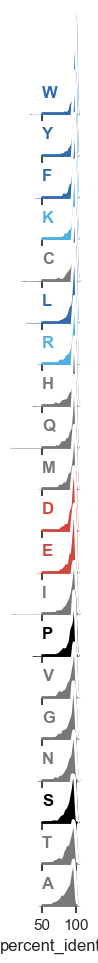

In [9]:
# # Create the data
# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
#pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(all_avg_percent_identities_df, row="AA", hue="AA", aspect=15, height=.5, palette = amino_acid_colors_white)

# Draw the densities in a few steps
g.map(sns.kdeplot, "percent_identity",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "percent_identity", clip_on=False, color="w", lw=2, bw_adjust=.5)


# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


# Apply x-axis limits to each axis in the grid
#i = 0
for ax in g.axes.flat:
    #median = avg_conservation_order["percent_identity"].iloc[i]
    
    ax.set_xlim(50, 100)
    # ax.axvline(median, color = "white", ymax = 1)
    # i += 1

g.map(label, "percent_identity")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.6)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

---

In [3]:
# Repeating using consensus sequence instead of reference

AD_alignments = glob.glob("../data/zoonomia_toga_mca/all_AD_alignments/*")
all_avg_percent_identities_df = []

all_percent_identities_df = []

for AD in AD_alignments:
    # For each AD, iterate through positions of alignment    
    # Load the alignment
    alignment = AlignIO.read(AD, "fasta")
    
    # Initialize a list to store percent identity for each position
    percent_identities = []


    # Get consensus sequence (>50% of positions have that AA)
    summary_align = AlignInfo.SummaryInfo(alignment)
    reference_seq = summary_align.dumb_consensus(0.5)

    
    AAs = []
    percent_identities = []
    positions = []
    
    # Iterate over each position in the alignment
    for i in range(alignment.get_alignment_length()):
        ref_AA = reference_seq[i]
        # if ref_AA == "X" or ref_AA == "-":
        #     print(AD)
        
        # Get the column (position) for all sequences
        column = alignment[:, i]
    
        # Calculating percent identity
        count = column.count(ref_AA)
        percent_identity = 100 * count / len(column)
    
        AAs.append(ref_AA)
        percent_identities.append(percent_identity)
        positions.append(i)
    
    percent_identities_df = pd.DataFrame({"AA" : AAs, "percent_identity" : percent_identities, "pos" : positions})
    percent_identities_df["AD"] = AD.split("/")[-1].split(".")[0]

    all_percent_identities_df.append(percent_identities_df)    
    avg_percent_identities_df = percent_identities_df[["AA", "percent_identity"]].groupby("AA").mean()
    avg_percent_identities_df["AD"] = AD.split("/")[-1].split(".")[0]

    # # Print percent identity for each position
    # for i, p_id in enumerate(percent_identities):
    #     print(f"Position {i + 1}: {p_id:.2f}%")
    all_avg_percent_identities_df.append(avg_percent_identities_df)

all_avg_percent_identities_df = pd.concat(all_avg_percent_identities_df)
all_avg_percent_identities_df = all_avg_percent_identities_df.reset_index()
display(all_avg_percent_identities_df)

percent_identities_df = pd.concat(all_percent_identities_df)
#percent_identities_df = percent_identities_df.reset_index()
percent_identities_df

,AA,percent_identity,AD
0,A,95.330144,SRF_406-508
1,D,87.649123,SRF_406-508
2,E,99.368421,SRF_406-508
3,F,99.684211,SRF_406-508
4,G,98.857143,SRF_406-508
...,...,...,...
11552,S,92.832995,FOS_209-371
11553,T,92.660889,FOS_209-371
11554,V,92.379021,FOS_209-371
11555,W,97.160243,FOS_209-371


,AA,percent_identity,pos,AD
0,H,99.368421,0,SRF_406-508
1,M,99.578947,1,SRF_406-508
2,M,99.578947,2,SRF_406-508
3,Y,99.578947,3,SRF_406-508
4,P,98.947368,4,SRF_406-508
...,...,...,...,...
158,P,97.160243,158,FOS_209-371
159,S,97.160243,159,FOS_209-371
160,S,97.160243,160,FOS_209-371
161,D,97.160243,161,FOS_209-371


In [198]:
avg_conservation_order = all_avg_percent_identities_df[["AA", "percent_identity"]].groupby("AA").median().sort_values(by = "percent_identity", ascending = True)
avg_conservation_order

,percent_identity
AA,
A,91.647573
T,91.764001
S,92.832995
N,93.122617
G,93.773196
V,93.849206
P,94.288504
I,94.307260
E,94.818841


In [199]:
all_avg_percent_identities_df['sort_order'] = pd.Categorical(all_avg_percent_identities_df['AA'], ordered=True, categories=avg_conservation_order.index)
all_avg_percent_identities_df = all_avg_percent_identities_df.sort_values('sort_order')
all_avg_percent_identities_df

,AA,percent_identity,AD,sort_order
9674,A,76.020408,RELB_414-579,A
9335,A,98.440748,MSX2_234-267,A
3751,A,93.485160,MEF2A_87-499,A
9348,A,96.920962,RARB_147-448,A
3731,A,96.257062,ERG_118-261,A
...,...,...,...,...
10465,W,97.693920,KLF6_1-201,W
7269,W,97.484277,CDK3_141-220,W
6691,W,97.641217,PPP2CA_151-250,W
7890,W,88.578089,YY2_2-102,W


In [200]:
all_avg_percent_identities_df = all_avg_percent_identities_df[all_avg_percent_identities_df["AA"] != "X"]

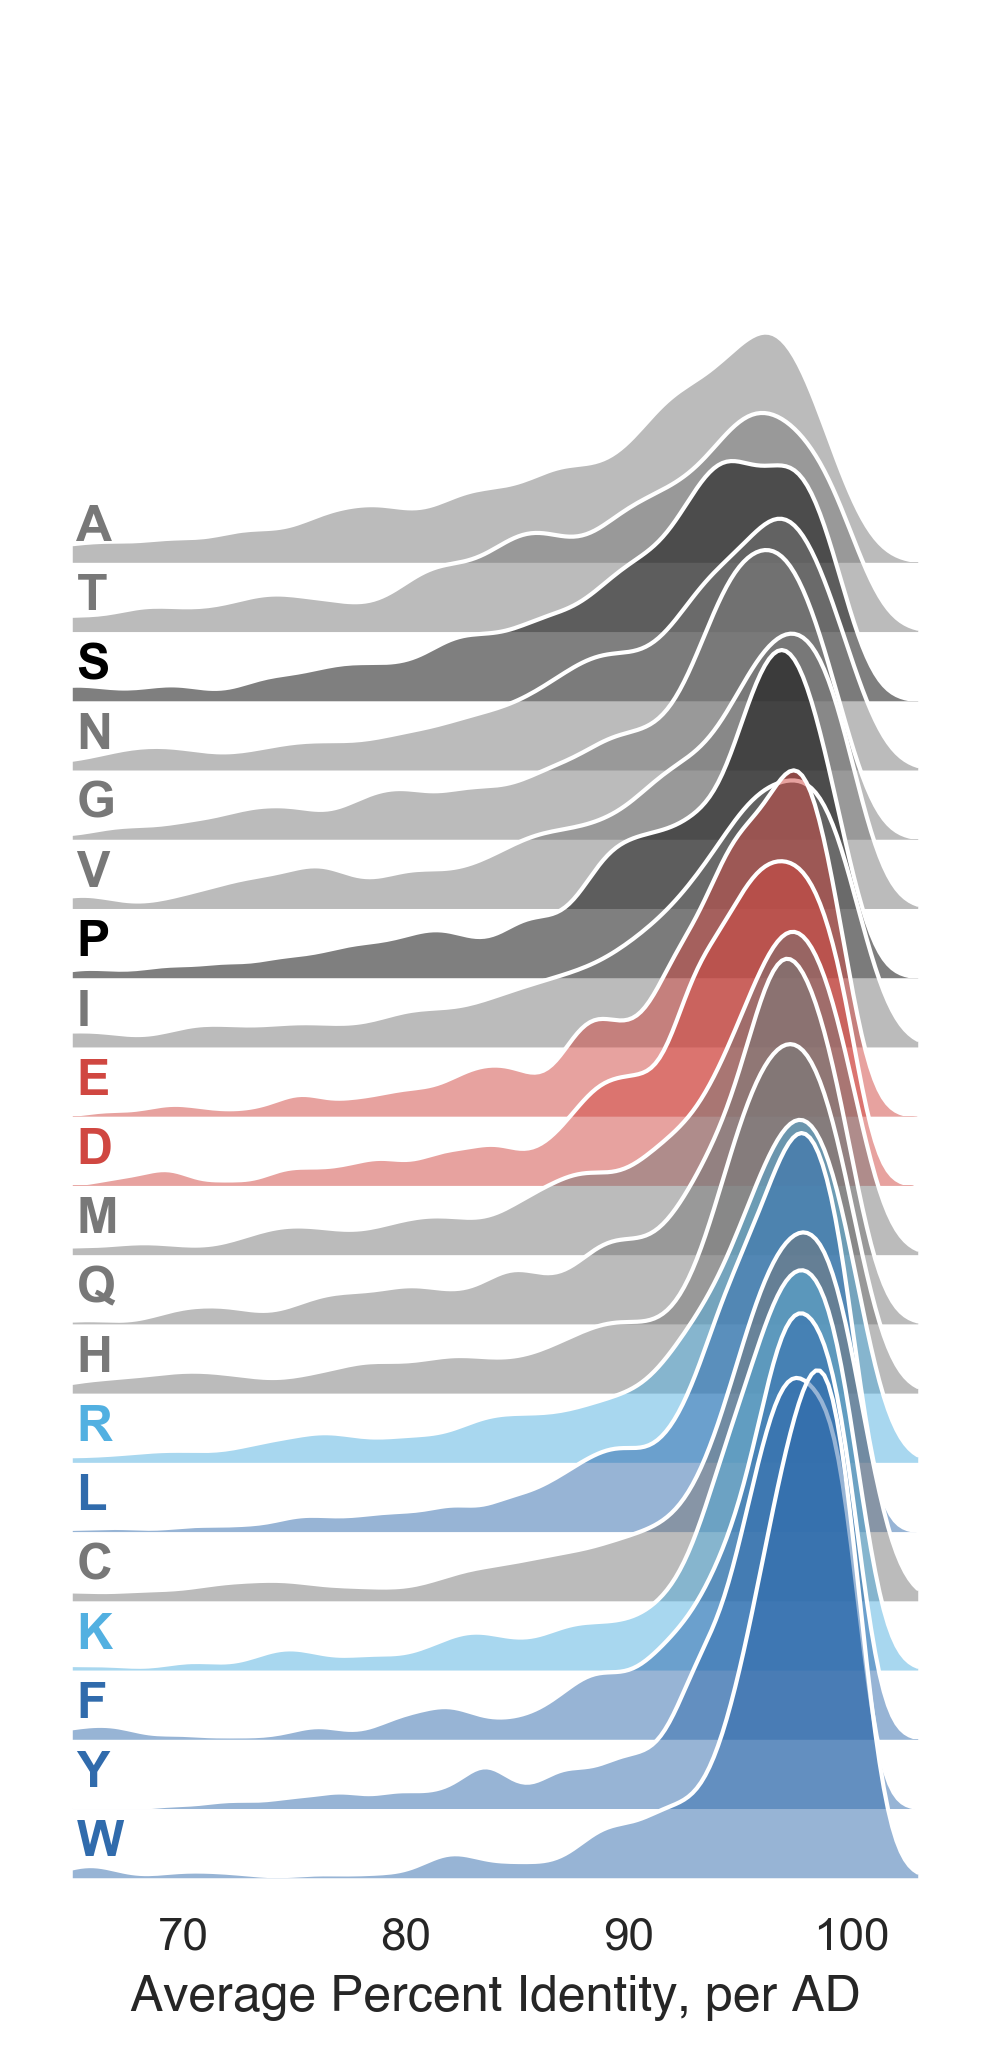

In [210]:
# # Create the data
# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.rcParams['figure.dpi'] = 300

# Initialize the FacetGrid object
#pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

#plt.figure(figsize=(20, 10))  # Adjust figure size for wider output

g = sns.FacetGrid(all_avg_percent_identities_df, row="AA", hue="AA", aspect=10, height=0.4, palette = amino_acid_colors_white)

# Draw the densities in a few steps
g.map(sns.kdeplot, "percent_identity",
      bw_adjust=.5, clip=(65, 103),
      fill=True, alpha=0.5, linewidth=0)
g.map(sns.kdeplot, "percent_identity", clip=(65, 103), color="w", lw=1, bw_adjust=.5)


# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.05, 0.065, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


# #Apply x-axis limits to each axis in the grid
# i = 0
# for ax in g.axes.flat:
#     median = avg_conservation_order["percent_identity"].iloc[i]
    
#     # ax.set_xlim(50, 100)
#     ax.axvline(median, color = "white")
#     i += 1

g.map(label, "percent_identity")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.87)

for ax in g.axes.flat[-g.axes.shape[1]:]:  # Bottom row (last `g.axes.shape[1]` axes)
    ax.set_xlabel("Average Percent Identity, per AD", font = "Helvetica")  # Set x-axis label for the bottom row

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

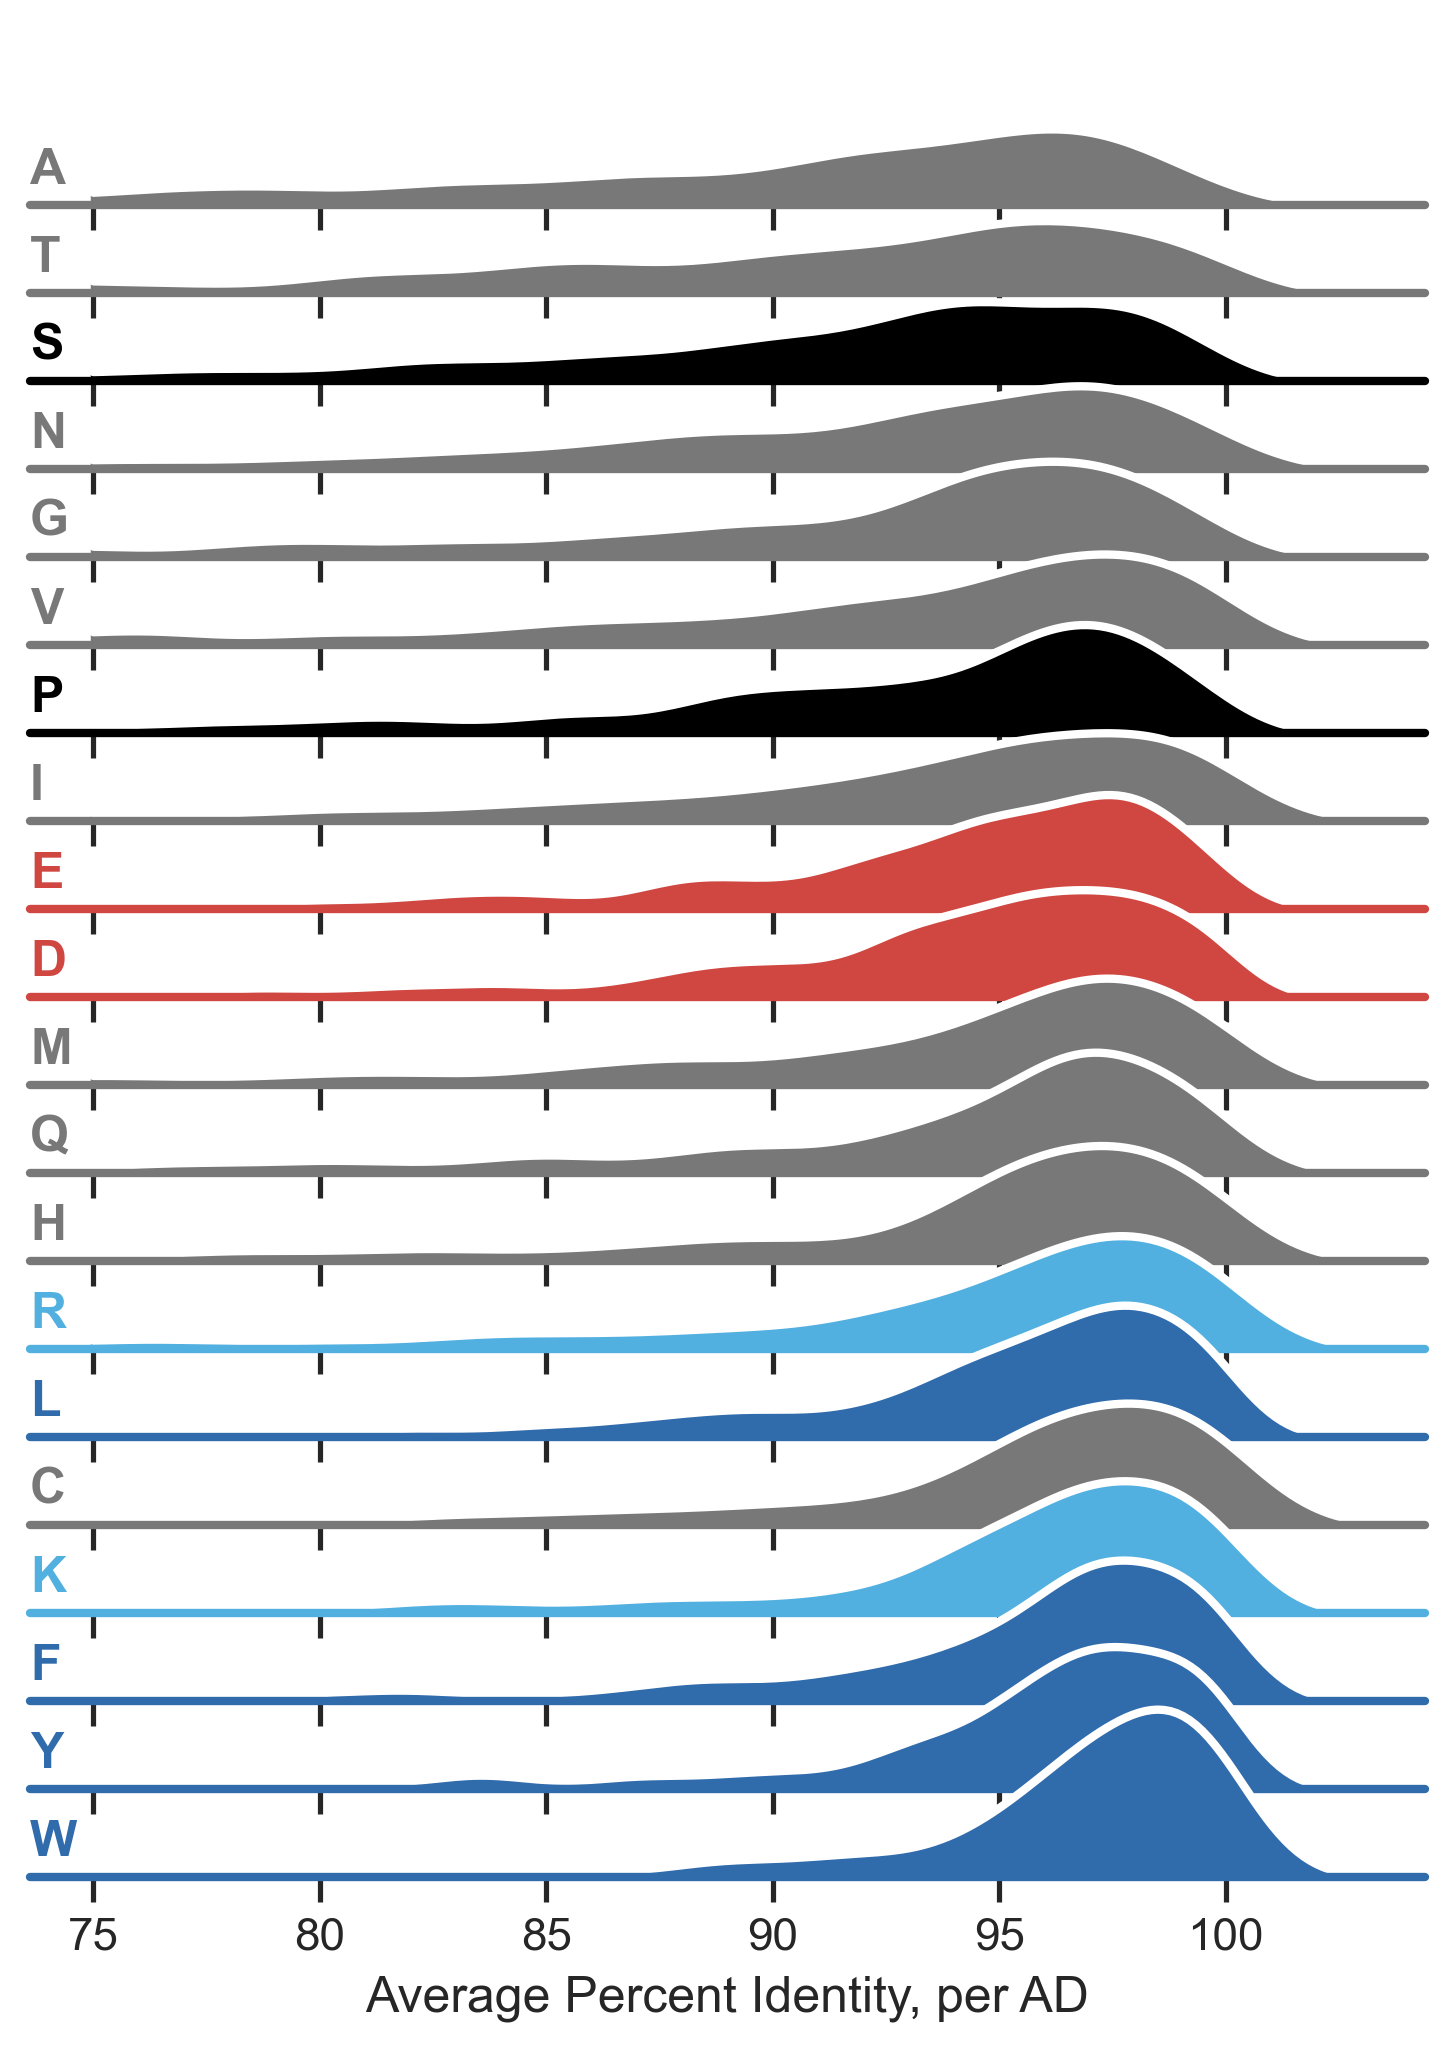

In [163]:
# # Create the data
# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
#pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

#plt.figure(figsize=(20, 10))  # Adjust figure size for wider output

g = sns.FacetGrid(all_avg_percent_identities_df, row="AA", hue="AA", aspect=15, height=0.4, palette = amino_acid_colors_white)

# Draw the densities in a few steps
g.map(sns.kdeplot, "percent_identity",
      bw_adjust=.5, clip=(75, 103),
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "percent_identity", clip=(75, 103), color="w", lw=2, bw_adjust=.5)


# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


# Apply x-axis limits to each axis in the grid
# #i = 0
# for ax in g.axes.flat:
#     #median = avg_conservation_order["percent_identity"].iloc[i]
    
#     ax.set_xlim(50, 100)
#     # ax.axvline(median, color = "white", ymax = 1)
#     # i += 1

g.map(label, "percent_identity")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

for ax in g.axes.flat[-g.axes.shape[1]:]:  # Bottom row (last `g.axes.shape[1]` axes)
    ax.set_xlabel("Average Percent Identity, per AD")  # Set x-axis label for the bottom row

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# 7. Interconversions
Do certain AA pairs interconvert more than others?

Plan:
- Calculated percent identity of each individual AA at each position of each AD
- For each pair of AAs:
    - Sum together percent identities per position
    - Maybe compare distribution of individual percent identities per AD vs paired percent identities
    - KS test comparing two distributions

In [230]:
AA_singles = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
AA_pairs = list(itertools.combinations(AA_singles, 2))
AA_pairs[:5]

[('A', 'C'), ('A', 'D'), ('A', 'E'), ('A', 'F'), ('A', 'G')]

In [162]:
# For each position of each AD, save the column for future computations
AD_alignments = glob.glob("../data/zoonomia_toga_mca/all_AD_alignments/*")

seqs_df = []

for AD in AD_alignments:
    # For each AD, iterate through positions of alignment    
    # Load the alignment
    alignment = AlignIO.read(AD, "fasta")
    
    columns = []
    positions = []
    
    # Iterate over each position in the alignment
    for i in range(alignment.get_alignment_length()):
        # Get the column (position) for all sequences
        column = alignment[:, i]
        columns.append(column)
        positions.append(i)
 
    # Save the sequence and position        
    return_df = pd.DataFrame({"seq" : columns, "pos" : positions})
    return_df["AD_name"] = AD.split("/")[-1].split(".")[0]
    return_df = return_df[["AD_name", "pos", "seq"]]
    seqs_df.append(return_df)    
    

seqs_df = pd.concat(seqs_df)
seqs_df

,AD_name,pos,seq
0,SRF_406-508,0,HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH...
1,SRF_406-508,1,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...
2,SRF_406-508,2,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...
3,SRF_406-508,3,YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY...
4,SRF_406-508,4,PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
...,...,...,...
158,FOS_209-371,158,------P------PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
159,FOS_209-371,159,------S------SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...
160,FOS_209-371,160,------S------SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...
161,FOS_209-371,161,------D------DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...


In [163]:
# Now, calculate percent identity per AA
seqs_df["len"] = seqs_df["seq"].str.len()

for AA in AA_singles:
    seqs_df[AA] = seqs_df["seq"].str.count(AA)/ seqs_df["len"]

seqs_df

,AD_name,pos,seq,len,A,C,D,E,F,G,...,M,N,P,Q,R,S,T,V,W,Y
0,SRF_406-508,0,HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,SRF_406-508,1,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.995789,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,SRF_406-508,2,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.995789,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,SRF_406-508,3,YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.995789
4,SRF_406-508,4,PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.989474,0.0,0.0,0.006316,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,FOS_209-371,158,------P------PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,493,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.971602,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
159,FOS_209-371,159,------S------SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,493,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.971602,0.0,0.0,0.0,0.000000
160,FOS_209-371,160,------S------SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,493,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.971602,0.0,0.0,0.0,0.000000
161,FOS_209-371,161,------D------DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,493,0.0,0.0,0.971602,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [164]:
i = 0
for AA1, AA2 in AA_pairs:
    if i%10 == 0:
        print(i)
    seqs_df[AA1+AA2] = seqs_df[AA1] + seqs_df[AA2]
    i += 1

seqs_df

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180


,AD_name,pos,seq,len,A,C,D,E,F,G,...,ST,SV,SW,SY,TV,TW,TY,VW,VY,WY
0,SRF_406-508,0,HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,SRF_406-508,1,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,SRF_406-508,2,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,SRF_406-508,3,YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.995789,0.0,0.0,0.995789,0.0,0.995789,0.995789
4,SRF_406-508,4,PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.006316,0.006316,0.006316,0.006316,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,FOS_209-371,158,------P------PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,493,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
159,FOS_209-371,159,------S------SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,493,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.971602,0.971602,0.971602,0.971602,0.0,0.0,0.000000,0.0,0.000000,0.000000
160,FOS_209-371,160,------S------SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,493,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.971602,0.971602,0.971602,0.971602,0.0,0.0,0.000000,0.0,0.000000,0.000000
161,FOS_209-371,161,------D------DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,493,0.0,0.0,0.971602,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [142]:
# Now. per AD, get an average percent identity per AA

per_AD_avg = seqs_df.drop(columns = ["pos", "seq", "len"])
per_AD_avg = per_AD_avg.groupby("AD_name").mean()
per_AD_avg

,A,C,D,E,F,G,H,I,K,L,...,ST,SV,SW,SY,TV,TW,TY,VW,VY,WY
AD_name,,,,,,,,,,,,,,,,,,,,,
ABRAXAS1_121-200,0.043634,0.025129,0.004063,0.051423,0.039312,0.057945,0.059731,0.030124,0.046843,0.144281,...,0.218375,0.202381,0.140813,0.166486,0.139130,0.077562,0.103235,0.061568,0.087241,0.025673
AEBP1_1088-1158,0.010902,0.000029,0.021716,0.176056,0.065266,0.037333,0.000589,0.005451,0.001562,0.018180,...,0.095940,0.061406,0.001945,0.015705,0.155578,0.096116,0.109877,0.061583,0.075343,0.015882
AHCTF1_1445-1698,0.067796,0.010610,0.081373,0.126446,0.020425,0.046687,0.026294,0.054983,0.048000,0.075455,...,0.134487,0.157544,0.084713,0.097344,0.122779,0.049948,0.062579,0.073006,0.085636,0.012805
AHR_118-126,0.108522,0.000000,0.000000,0.000000,0.109463,0.108522,0.000235,0.000235,0.000000,0.324859,...,0.000706,0.109228,0.000706,0.000706,0.108522,0.000000,0.000000,0.108522,0.108522,0.000000
AHR_266-268,0.321328,0.000000,0.000000,0.000000,0.327684,0.000000,0.000000,0.309322,0.000000,0.002119,...,0.005650,0.019068,0.000000,0.000000,0.024718,0.005650,0.005650,0.019068,0.019068,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF641_171-265,0.013760,0.010214,0.095495,0.116704,0.020763,0.055107,0.021900,0.012132,0.008118,0.116771,...,0.180263,0.149063,0.137444,0.128501,0.094358,0.082739,0.073796,0.051539,0.042596,0.030977
ZNF644_902-981,0.048355,0.024947,0.067516,0.095090,0.062420,0.066215,0.073195,0.012075,0.037367,0.087473,...,0.178238,0.131184,0.118684,0.168524,0.097001,0.084501,0.134342,0.037447,0.087288,0.074788
ZNF687_2-81,0.136204,0.000486,0.136042,0.090092,0.024919,0.140740,0.024298,0.048029,0.026215,0.039174,...,0.112095,0.106237,0.080103,0.080103,0.058126,0.031992,0.031992,0.026134,0.026134,0.000000


In [147]:
t_test_p_vals = []
AA1s = []
AA2s = []

for AA1 in AA_singles:
    for AA2 in AA_singles:
        if AA1 != AA2:
            pair_name = ""
            if AA1 + AA2 in per_AD_avg.columns:
                pair_name = AA1 + AA2
            else:
                pair_name = AA2 + AA1
            
            t_test_p_vals.append(stats.ttest_ind(per_AD_avg[AA1], per_AD_avg[pair_name])[1])
            AA1s.append(AA1)
            AA2s.append(AA2)
            
avg_pair_p_vals = pd.DataFrame({"AA1" : AA1s, 
                            "AA2" : AA2s, 
                            "t_test_p_val" : t_test_p_vals})
avg_pair_p_vals

,AA1,AA2,t_test_p_val
0,A,C,3.376584e-08
1,A,D,1.399042e-78
2,A,E,7.906749e-88
3,A,F,2.785647e-30
4,A,G,5.945672e-88
...,...,...,...
375,Y,R,2.273057e-50
376,Y,S,9.342807e-231
377,Y,T,1.334050e-118
378,Y,V,2.932852e-102


In [149]:
avg_pair_p_vals.sort_values("t_test_p_val")[:15]

,AA1,AA2,t_test_p_val
357,W,S,1.450595e-317
33,C,S,1.297051e-297
351,W,L,3.471291e-291
204,M,S,5.840903e-274
147,I,S,1.596641e-272
280,R,S,2.377308e-270
90,F,S,1.060638e-268
27,C,L,1.174014e-266
199,M,L,1.021872e-264
354,W,P,1.941832e-263


In [153]:
avg_pair_p_vals["AA1+AA2"] = avg_pair_p_vals["AA1"] + avg_pair_p_vals["AA2"]
avg_pair_p_vals

,AA1,AA2,t_test_p_val,AA1+AA2
0,A,C,3.376584e-08,AC
1,A,D,1.399042e-78,AD
2,A,E,7.906749e-88,AE
3,A,F,2.785647e-30,AF
4,A,G,5.945672e-88,AG
...,...,...,...,...
375,Y,R,2.273057e-50,YR
376,Y,S,9.342807e-231,YS
377,Y,T,1.334050e-118,YT
378,Y,V,2.932852e-102,YV


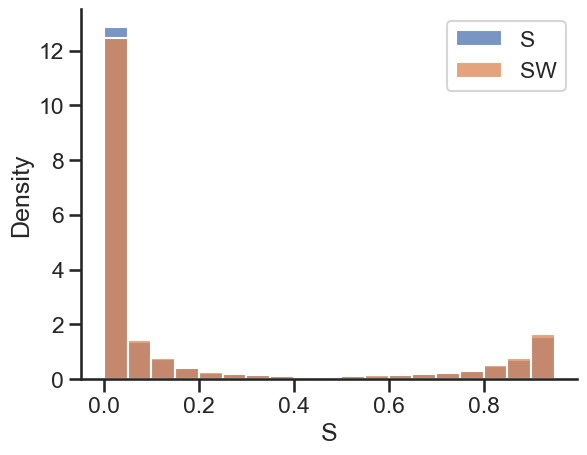

In [168]:
#sns.histplot(seqs_df[seqs_df["DE"] != 0]["E"], bins = np.arange(0, 1, 0.05), stat = "density")
sns.set_theme(style="ticks")
sns.set_context('talk')

sns.histplot(seqs_df[seqs_df["SW"] != 0]["S"], bins = np.arange(0, 1, 0.05), stat = "density", label = "S")
sns.histplot(seqs_df[seqs_df["SW"] != 0]["SW"], bins = np.arange(0, 1, 0.05), stat = "density", label = "SW")
plt.legend()
sns.despine();

In [176]:
seqs_df

,AD_name,pos,seq,len,A,C,D,E,F,G,...,ST,SV,SW,SY,TV,TW,TY,VW,VY,WY
0,SRF_406-508,0,HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,SRF_406-508,1,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,SRF_406-508,2,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,SRF_406-508,3,YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.995789,0.0,0.0,0.995789,0.0,0.995789,0.995789
4,SRF_406-508,4,PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.006316,0.006316,0.006316,0.006316,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,FOS_209-371,158,------P------PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,493,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
159,FOS_209-371,159,------S------SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,493,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.971602,0.971602,0.971602,0.971602,0.0,0.0,0.000000,0.0,0.000000,0.000000
160,FOS_209-371,160,------S------SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,493,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.971602,0.971602,0.971602,0.971602,0.0,0.0,0.000000,0.0,0.000000,0.000000
161,FOS_209-371,161,------D------DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,493,0.0,0.0,0.971602,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [208]:
AA_singles

['A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [217]:
most_common_aa = []

for i in range(len(seqs_df)):
    row = seqs_df.iloc[i]
    max_aa = ""
    max_aa_count = 0
    
    for AA in AA_singles:
        if row[AA] > max_aa_count:
            max_aa = AA
            max_aa_count = row[AA]

    most_common_aa.append(max_aa)
    
    #seqs_df.iloc[0]

In [218]:
seqs_df["most_common_aa"] = most_common_aa
seqs_df

,AD_name,pos,seq,len,A,C,D,E,F,G,...,SV,SW,SY,TV,TW,TY,VW,VY,WY,most_common_aa
0,SRF_406-508,0,HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,H
1,SRF_406-508,1,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,M
2,SRF_406-508,2,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,M
3,SRF_406-508,3,YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.995789,0.0,0.0,0.995789,0.0,0.995789,0.995789,Y
4,SRF_406-508,4,PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,475,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.006316,0.006316,0.006316,0.0,0.0,0.000000,0.0,0.000000,0.000000,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,FOS_209-371,158,------P------PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,493,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,P
159,FOS_209-371,159,------S------SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,493,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.971602,0.971602,0.971602,0.0,0.0,0.000000,0.0,0.000000,0.000000,S
160,FOS_209-371,160,------S------SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,493,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.971602,0.971602,0.971602,0.0,0.0,0.000000,0.0,0.000000,0.000000,S
161,FOS_209-371,161,------D------DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,493,0.0,0.0,0.971602,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,D


In [236]:
seqs_df.loc[:, [AA1 + AA2 for AA1, AA2 in AA_pairs] + [ "most_common_aa"]].T

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
AC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991579,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991579,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.971602,0.0
AE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991579,0.0,...,0.0,0.0,0.0,0.0,0.971602,0.0,0.0,0.0,0.0,0.0
AF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991579,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.991579,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TY,0.0,0.0,0.0,0.995789,0.0,0.0,0.0,0.0,0.004211,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.995789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VY,0.0,0.0,0.0,0.995789,0.0,0.0,0.0,0.0,0.0,0.995789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WY,0.0,0.0,0.0,0.995789,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [224]:
len(AA_pairs)

190

In [ ]:
for i in range(len(seqs_df)):
    row = seqs_df.iloc[0]
    most_common_aa = row["most_common_aa"]
    
    for AA_pair in AA_pairs:

In [222]:
seqs_df.loc[:, AA_singles]

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.993684,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.995789,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.995789,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.995789
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.989474,0.0,0.0,0.006316,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.971602,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
159,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.971602,0.0,0.0,0.0,0.000000
160,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.971602,0.0,0.0,0.0,0.000000
161,0.0,0.0,0.971602,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


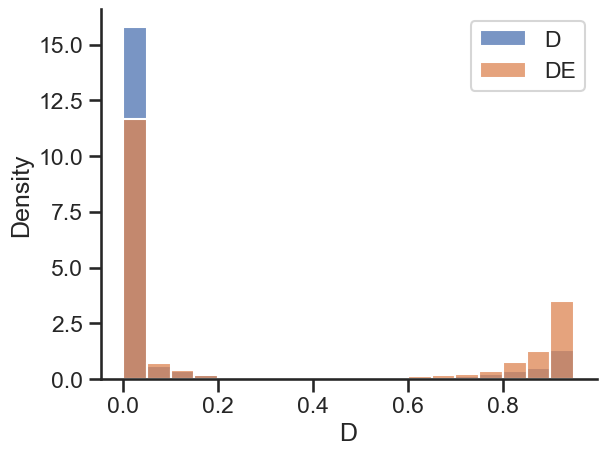

In [170]:
#sns.histplot(seqs_df[seqs_df["DE"] != 0]["E"], bins = np.arange(0, 1, 0.05), stat = "density")
sns.set_theme(style="ticks")
sns.set_context('talk')

sns.histplot(seqs_df[seqs_df["DE"] != 0]["D"], bins = np.arange(0, 1, 0.05), stat = "density", label = "D")
sns.histplot(seqs_df[seqs_df["DE"] != 0]["DE"], bins = np.arange(0, 1, 0.05), stat = "density", label = "DE")
plt.legend()
sns.despine();

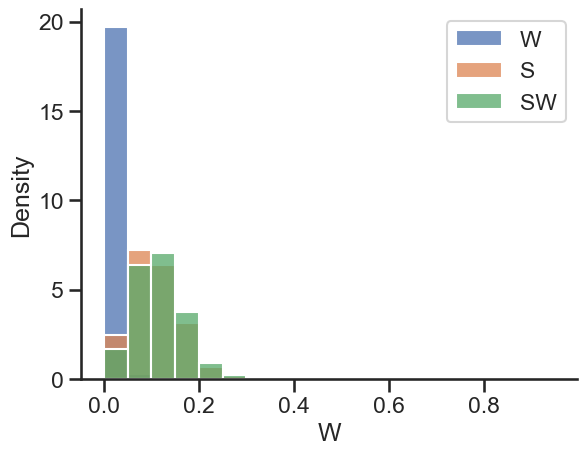

In [159]:
# Average 

#sns.histplot(seqs_df[seqs_df["DE"] != 0]["E"], bins = np.arange(0, 1, 0.05), stat = "density")
sns.set_theme(style="ticks")
sns.set_context('talk')



sns.histplot(per_AD_avg["W"], bins = np.arange(0, 1, 0.05), stat = "density", label = "W")
sns.histplot(per_AD_avg["S"], bins = np.arange(0, 1, 0.05), stat = "density", label = "S")

sns.histplot(per_AD_avg["SW"], bins = np.arange(0, 1, 0.05), stat = "density", label = "SW")
plt.legend()
sns.despine();

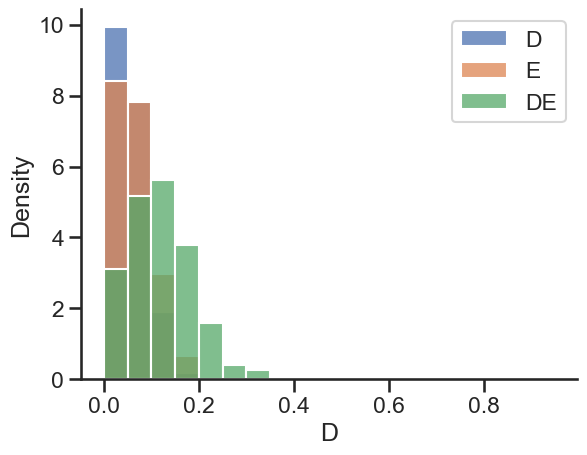

In [161]:
#sns.histplot(seqs_df[seqs_df["DE"] != 0]["E"], bins = np.arange(0, 1, 0.05), stat = "density")
sns.set_theme(style="ticks")
sns.set_context('talk')



sns.histplot(per_AD_avg["D"], bins = np.arange(0, 1, 0.05), stat = "density", label = "D")
sns.histplot(per_AD_avg["E"], bins = np.arange(0, 1, 0.05), stat = "density", label = "E")

sns.histplot(per_AD_avg["DE"], bins = np.arange(0, 1, 0.05), stat = "density", label = "DE")
plt.legend()
sns.despine();

In [186]:
t_test_p_vals = []
AA1s = []
AA2s = []

for AA1 in AA_singles:
    for AA2 in AA_singles:
        if AA1 != AA2:
            pair_name = ""
            if AA1 + AA2 in seqs_df.columns:
                pair_name = AA1 + AA2
            else:
                pair_name = AA2 + AA1
            
            with_AA1 = seqs_df[seqs_df[AA1] != 0]
            t_test_p_vals.append(stats.ttest_ind(with_AA1[AA1], with_AA1[pair_name])[1])
            AA1s.append(AA1)
            AA2s.append(AA2)
            
pair_p_vals = pd.DataFrame({"AA1" : AA1s, 
                            "AA2" : AA2s, 
                            "t_test_p_val" : t_test_p_vals})
pair_p_vals

,AA1,AA2,t_test_p_val
0,A,C,3.623267e-01
1,A,D,7.122320e-10
2,A,E,7.363629e-17
3,A,F,3.361717e-01
4,A,G,1.887031e-178
...,...,...,...
375,Y,R,4.017610e-01
376,Y,S,7.156747e-06
377,Y,T,5.521745e-01
378,Y,V,5.489566e-01


In [189]:
pair_p_vals.sort_values(by = "t_test_p_val")

,AA1,AA2,t_test_p_val
304,T,A,0.000000e+00
297,S,P,0.000000e+00
319,T,S,0.000000e+00
40,D,E,5.514623e-288
11,A,P,1.302166e-265
...,...,...,...
369,Y,K,9.135336e-01
353,W,N,9.174687e-01
55,D,W,9.232383e-01
226,N,W,9.375212e-01


In [190]:
import statsmodels.stats.multitest as smm

In [191]:
pair_p_vals["bh_decision"],  pair_p_vals["bh_p"] = smm.fdrcorrection(pair_p_vals["t_test_p_val"], 
                                                              alpha=0.01, 
                                                              method='indep', 
                                                              is_sorted=False)
pair_p_vals

,AA1,AA2,t_test_p_val,bh_decision,bh_p
0,A,C,3.623267e-01,False,4.899791e-01
1,A,D,7.122320e-10,True,2.761716e-09
2,A,E,7.363629e-17,True,3.681814e-16
3,A,F,3.361717e-01,False,4.679313e-01
4,A,G,1.887031e-178,True,6.518833e-177
...,...,...,...,...,...
375,Y,R,4.017610e-01,False,5.319483e-01
376,Y,S,7.156747e-06,True,2.211028e-05
377,Y,T,5.521745e-01,False,6.592334e-01
378,Y,V,5.489566e-01,False,6.592334e-01


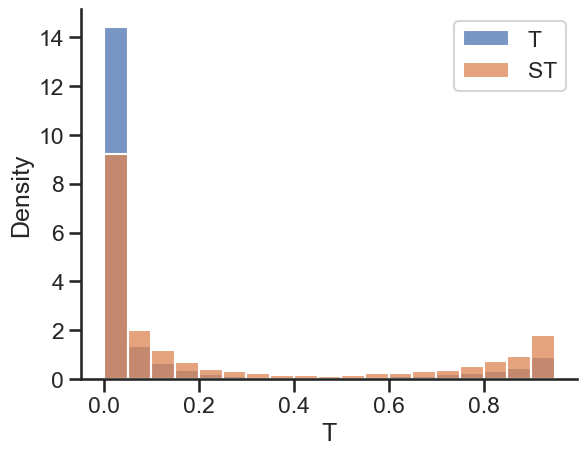

In [195]:
#sns.histplot(seqs_df[seqs_df["DE"] != 0]["E"], bins = np.arange(0, 1, 0.05), stat = "density")
sns.set_theme(style="ticks")
sns.set_context('talk')

sns.histplot(seqs_df[seqs_df["T"] != 0]["T"], bins = np.arange(0, 1, 0.05), stat = "density", label = "T")
sns.histplot(seqs_df[seqs_df["T"] != 0]["ST"], bins = np.arange(0, 1, 0.05), stat = "density", label = "ST")
plt.legend()
sns.despine();

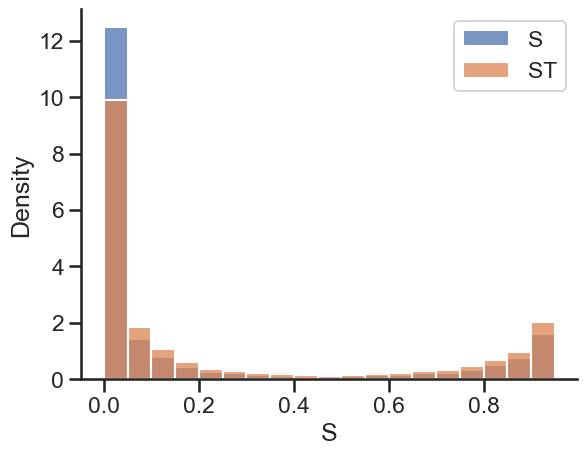

In [196]:
#sns.histplot(seqs_df[seqs_df["DE"] != 0]["E"], bins = np.arange(0, 1, 0.05), stat = "density")
sns.set_theme(style="ticks")
sns.set_context('talk')

sns.histplot(seqs_df[seqs_df["S"] != 0]["S"], bins = np.arange(0, 1, 0.05), stat = "density", label = "S")
sns.histplot(seqs_df[seqs_df["S"] != 0]["ST"], bins = np.arange(0, 1, 0.05), stat = "density", label = "ST")
plt.legend()
sns.despine();

In [87]:
"AD" in seqs_df.columns

True

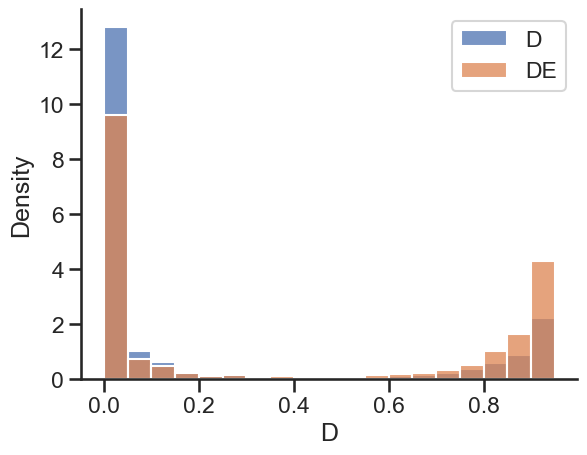

In [82]:
#sns.histplot(seqs_df[seqs_df["DE"] != 0]["E"], bins = np.arange(0, 1, 0.05), stat = "density")
sns.set_theme(style="ticks")
sns.set_context('talk')

sns.histplot(seqs_df[seqs_df["D"] != 0]["D"], bins = np.arange(0, 1, 0.05), stat = "density", label = "D")
sns.histplot(seqs_df[seqs_df["D"] != 0]["DE"], bins = np.arange(0, 1, 0.05), stat = "density", label = "DE")
plt.legend()
sns.despine();

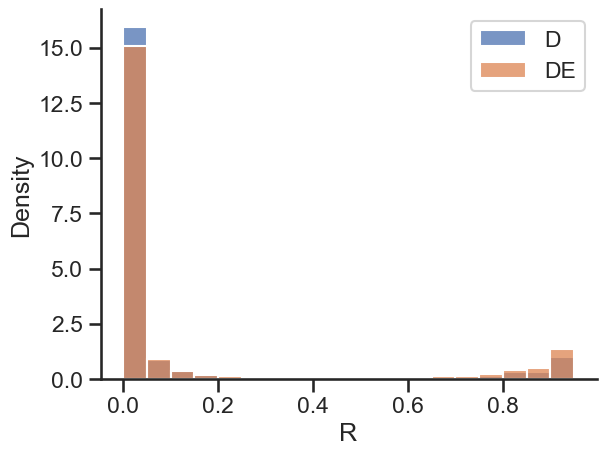

In [84]:
#sns.histplot(seqs_df[seqs_df["DE"] != 0]["E"], bins = np.arange(0, 1, 0.05), stat = "density")
sns.set_theme(style="ticks")
sns.set_context('talk')

sns.histplot(seqs_df[seqs_df["R"] != 0]["R"], bins = np.arange(0, 1, 0.05), stat = "density", label = "D")
sns.histplot(seqs_df[seqs_df["R"] != 0]["KR"], bins = np.arange(0, 1, 0.05), stat = "density", label = "DE")
plt.legend()
sns.despine();

In [ ]:
# Now, iterating through pairs
pairs_df = singles_all_percent_identities_df.copy(deep = True)

# Calculate percent identity per pos per AD
for AA1, AA2 in AA_pairs:
    
    

In [ ]:
# Now, aggreating
# Calculate average pair identity per AD

In [22]:
for AD in list(set(percent_identities_df["AD"]))[:1]:
    print(AD)
    rows = percent_identities_df[percent_identities_df["AD"] == AD]
    display(rows)

HMGA2_93-109


,AA,percent_identity,pos,AD
0,A,0.214592,0,HMGA2_93-109
1,Q,0.214592,1,HMGA2_93-109
2,E,0.214592,2,HMGA2_93-109
3,E,0.643777,3,HMGA2_93-109
4,T,0.214592,4,HMGA2_93-109
5,E,0.214592,5,HMGA2_93-109
6,E,0.214592,6,HMGA2_93-109
7,T,0.214592,7,HMGA2_93-109
8,S,0.214592,8,HMGA2_93-109
9,S,0.214592,9,HMGA2_93-109


In [ ]:
percent_identities_df